<div style='background-image: url("https://www.geophysik.uni-muenchen.de/ROMY/theme/images/ringlaser_wideformat.jpg") ; padding: 0px ; background-size: cover ; border-radius: 15px ; height: 250px; background-position: 0% 80%'>
    <div style="float: left ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 40% ; height: 150px">
        <div style="position: relative ; top: 50%;  transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%">ROMY - <br> Synthetic Sagnac Modulation </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.7)"></div>
        </div>
    </div>

# Modulation of synthetic Sagnac signal

### Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import matplotlib.pyplot as plt
import obspy 
import time


from scipy.fft import fft
from scipy import optimize
from scipy.signal import butter, lfilter, resample, hilbert, ricker, decimate


### Load Processing Methods

In [41]:
from QuerrySeismoData import __querry_seismo_data
from FastFourierTransform import __fast_fourier_transform
# from CreateSyntheticEvent import __create_synthetic_event
from CreateSyntheticEventV2 import __create_synthetic_event_v2
from Modulation import __modulation
from ResampleDigitalSignal import __resample_digital_signal
from ProcessingModeltrace import __processing_modeltrace
from Interpolation import __interpolation
from TracePadding import __trace_padding
from EchoPerformance import __echo_performance


### Load Plotting Methods

In [3]:
from MakeplotModulatedSignal import __makeplot_modulated_signal
from MakeplotTraceAndSpectrum import __makeplot_trace_and_spectrum
from MakeplotCompareSchemes import __makeplot_compare_schemes

### Setting crucial parameters

In [4]:
from RingLaser import RingLaser

## define G-Ring
G = RingLaser(side=4., form="square", wl=632.8e-9, lat=49.16)
G_sgnc = G.get_sagnac_frequency()


## define ROMY Z-Ring
ROMY_Z = RingLaser(side=11., form="triangle", wl=632.8e-9, lat=49.16)
ROMY_Z_sgnc = ROMY_Z.get_sagnac_frequency()


print(f'Sagnac frequency (G-ring) : {round(G_sgnc,3)} Hz')
print(f'Sagnac frequency (ROMY Z-ring) : {round(ROMY_Z_sgnc,3)} Hz')


Sagnac frequency (G-ring) : 348.721 Hz
Sagnac frequency (ROMY Z-ring) : 553.669 Hz


In [25]:
## dividing the original parameters (5kHz, 1600s, ..) by a factor 'div' to reduce calulcation time
div = 1

## set Parameters -------------------------------------

## assumed sagnac frequency 
sgnc = 550/div

## sampling, time duration and points 
sps = 5000/div # samples per second (5 kHz)
T   = 1600/div # seconds 
pts = sps * T # points



### Querry seismic data 

Querry data of RLAS for an arbitrary event on 2020-10-30. 


Get data:  BW.RLAS..BJZ (30.0) ...

Using Eida-Routing...

Requesting from 1 network(s) and 1 stations

removing response ...

output VEL

Finished
_______________



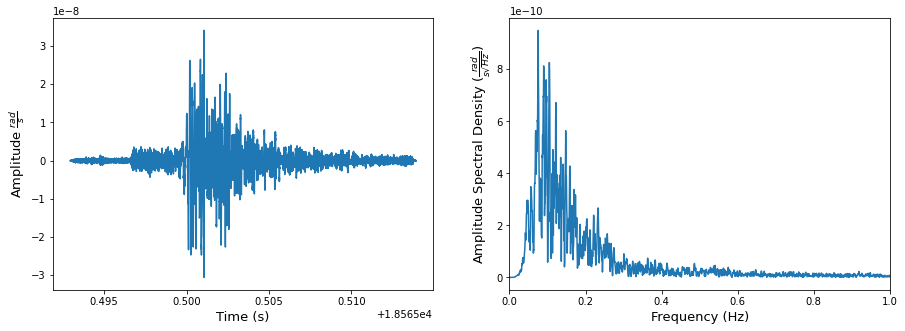

In [26]:
## set starttime and endtime
tbeg = obspy.UTCDateTime(2020, 10, 30, 11, 50)
tend = obspy.UTCDateTime(2020, 10, 30, 12, 20)

## get stream data
RLAS, RLAS_inv = __querry_seismo_data("BW.RLAS..BJZ", 
                                      tbeg, 
                                      tend, 
                                      restitute=True,
                                      )


## _________________________________________
## Plotting

__makeplot_trace_and_spectrum(RLAS[0], 
                              RLAS[0].times("Matplotlib"), 
                              fmax=1.);


### Process Seismic Modeltrace

### Setup Signal

In [49]:
option = 3

#### Option 1 - Real Trace

The synthetic signal (later modulated on top of the carrier frequency) is genereated using the real RLAS event.

In [27]:

if option == 1:

    interpolation = True; padding = False
#     padding = True; interpolation = False
    
    
    time_shift = 2 # minutes
    duration = T # seconds

    modeltrace, time_modeltrace = __processing_modeltrace(RLAS, time_shift, duration)

    modeltrace = modeltrace.data


    if interpolation and not padding:
        modeltrace, time_modeltrace = __interpolation(modeltrace, time_modeltrace, T, sps)
        print(f"\nmodeltrace is interpolated to sampling rate: {sps} Hz")
        
    elif padding and not interpolation:  
        modeltrace, time_modeltrace = __trace_padding(modeltrace, sps, T)
        print(f"\nmodeltrae is padded with white noise to extend trace to {T} seconds")
              
    else:
        print("\nselect either interpolation or padding!")
    
    ## _________________________________________
    ## Plotting
    
    __makeplot_trace_and_spectrum(modeltrace[::10], 
                                  time_modeltrace[::10], 
                                  fmax=1.
                                 );
    

#### Option 2 - Synthetic Trace

The synthetic signal (later modulated on top of the carrier signal) is generated using several ricker wavelets and white noise

In [28]:

if option == 2:

    ## define central_frequency of trace (more or less)
    central_frequency = 0.05
    
    ## call synthetic event generator (version2)
    modeltrace, time_modeltrace =  __create_synthetic_event_v2(central_frequency, T, sps, noise=False, padding=10)
    
    
    __makeplot_trace_and_spectrum(modeltrace[::100], time_modeltrace[::100], fmax=10*central_frequency);
    

#### Option 3 - Linear Chirp

The synthetic signal ist a linear chirp (with frequency range f0 - f1)

In [29]:

if option == 3:
    
    Npts = int(T*sps)
    
    f0 = .001   
    f1 = 0.1
    
    t = np.arange(0, T+1/sps, 1/sps)

    ## define splope
    m = (f1-f0)/2/t[-1]

    ## create lilnear chirp signal
    modeltrace = np.sin(2*np.pi*(f0 + m * t)*t)
    time_modeltrace = t
    

### Modulation

There are 3 different cases implemented for the modulation scheme:

case == 1:

$ s_1(t) = sin( \ 2\pi \ (f_c + \kappa \cdot f_m ) \cdot t \ )$
        
case == 2:

$ s_2(t) = sin( \ \omega_c \cdot t - m_{fm} \cdot cos(\omega_m \cdot t ) \ )$

case == 3: 

$ s_2(t) = A \cos( \ f_{c} +  2 \pi S_f \int_0^t f_{mod}(t) dt \ ) $

In [66]:
from tqdm import tqdm


def __modulation(f_sgnc, data, timeline, T, sps, case=1):

    ## check if arrays have the same size
    if data.size != timeline.size:
        print(f"Difference in lengths: event = {data.size} and timeline ={timeline.size}")

    ## _______________________________________________
    ##
    if case == 1:
        print(f"\nModulation option {case} is executed ...")

        ## actual modulation according to case 1
        factor = 0.1
        
        ## modulation 
        synthetic_signal = np.sin(2*np.pi*(f_sgnc + factor * data) * timeline)
    
    ## _______________________________________________
    ##    
    if case == 2:
        print(f"\nModulation option {case} is executed ...")

        ## amplitude of carrier frequency
        A_c = 1.0
        
        factor = 0.1 # carrier deviation / 
        
        w_c = 2*np.pi*f_sgnc
        
        synthetic_signal = A_c * np.sin(w_c * timeline - factor * np.cos(data*timeline))
        
        ## alternative exchanging sine and cosine
#         synthetic_signal = A_c * np.cos(w_c * time - factor * np.sin(data*time))

    ## _______________________________________________
    ##    
    if case == 3:
        print(f"\nModulation option {case} is executed ...")

        fraction = 100
        Npts = int(T*sps/fraction)
        
        tt = np.arange(0, T/fraction, 1/sps)
        
        romy_scale = ROMY_Z.get_scale_factor()
        romy_sgnc = ROMY_Z.get_sagnac_frequency()
        
#         fm = sgnc + romy_scale * modeltrace[::fraction]
        fm = sgnc + 0.1* modeltrace[::fraction]
       
        ifm = np.zeros(Npts)

#         print(' Integrating ... ')
#         t1 = time.time()
#         for i in range(Npts):
#             ifm[i] = 2*np.pi*np.sum(fm[:i])
#         t2 = time.time()
#         print(t2-t1)
        
        
        ## start clock
        t1 = time.time()
        
        print('\nIntegrating ... '); time.sleep(1)

        ifm = [fm[:i].dot(fm[:i]) for i in tqdm(range(0,modeltrace.size))]

        ## resample to original length
        ifm = resample(ifm, timeline.size)

        ifm = ifm / sps

        synthetic_signal = np.cos(ifm)
        fsignal = fm
        
        ## end clock
        t2 = time.time()    
        
        __echo_performance(t1, t2)
        
    return synthetic_signal, timeline


In [ ]:
syn_signal_1, time_axis_1 = __modulation(sgnc, modeltrace, time_modeltrace, T, sps, case=3)

plt.plot(time_axis_1[:200], syn_signal_1[:200])


Modulation option 3 is executed ...

Integrating ... 


 57%|█████▋    | 4536119/8000001 [00:30<00:21, 161126.15it/s]

### Compare Schemes

In [ ]:
# syn_signal_1, time_axis_1 = __modulation(sgnc, modeltrace, time_modeltrace, T, sps, case=1)
syn_signal_2, time_axis_2 = __modulation(sgnc, modeltrace, time_modeltrace, T, sps, case=2)
# syn_signal_1, time_axis_1 = __modulation(sgnc, modeltrace, time_modeltrace, T, sps, case=3)


for i, spl in enumerate(time_axis_2-time_axis_1):
    if spl != 0:
        print(i)
        

## _________________________________________
## Plotting

__makeplot_compare_schemes(syn_signal_1, time_axis_1, syn_signal_2, time_axis_2, number_of_samples=100);


In [38]:
for i, spl in enumerate(time_axis_2-time_axis_1):
    if spl != 0:
        print(i)

In [ ]:

##  actual modulation
syn_signal, time_axis = __modulation(sgnc, modeltrace, time_modeltrace, T, sps, case=2)


## _________________________________________
## Plotting

__makeplot_trace_and_spectrum(modeltrace[::10], 
                              time_modeltrace[::10], 
                              fmax=1.
                             );

__makeplot_modulated_signal(syn_signal, 
                            time_axis,
                           );



### Write Traces to Output

Write the modulated signal and the used event to individual .mseed-files, in order to import them for the demodulation. Before the export they need to be converted to trace.objects and headers have to be set.

In [ ]:
## create trace object
synthetic_signal = obspy.core.trace.Trace(syn_signal)
time_synthetic_signal = obspy.core.trace.Trace(time_axis)

## edit header of trace 
synthetic_signal.stats.starttime = tbeg
synthetic_signal.stats.sampling_rate = 1/sps

time_synthetic_signal.stats.starttime = tbeg
time_synthetic_signal.sampling_rate = 1/sps

##create a stream
synthetic_signal_out = obspy.core.stream.Stream(traces=[synthetic_signal, time_synthetic_signal])

## write trace object to file
synthetic_signal_out.write(f"synthetic_signal_opt{option}.mseed", format="MSEED")

In [ ]:
## create trace object
synthetic_event = obspy.core.trace.Trace(modeltrace)
time_sythetic_event = obspy.core.trace.Trace(time_modeltrace)

## edit header of trace 
synthetic_event.stats.starttime = tbeg
synthetic_event.stats.sampling_rate = 1/sps

time_sythetic_event.stats.starttime = tbeg
time_sythetic_event.sampling_rate = 1/sps

##create a stream
synthetic_event_out = obspy.core.stream.Stream(traces=[synthetic_event, time_sythetic_event])

## write trace object to file
synthetic_event_out.write(f"synthetic_event_opt{option}.mseed", format="MSEED")